In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime
from sklearn import model_selection, metrics

# Import Data

In [2]:
df = pd.read_csv('LBMA-GOLD.csv', index_col='Date', parse_dates=True)

df = df.asfreq('D')

In [3]:
df.head()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
1968-01-02,35.18,NaN,14.641,NaN,NaN,NaN
1968-01-03,35.16,NaN,14.617,NaN,NaN,NaN
1968-01-04,35.14,NaN,14.603,NaN,NaN,NaN
1968-01-05,35.14,NaN,14.597,NaN,NaN,NaN
1968-01-06,NaN,NaN,NaN,NaN,NaN,NaN


# Subset & Clean Data

In [4]:
df = df.loc['2013-10-24':'2023-10-24', 'USD (PM)']

In [5]:
df.head()

Date
2013-10-24    1344.75
2013-10-25    1347.75
2013-10-26        NaN
2013-10-27        NaN
2013-10-28    1361.00
Freq: D, Name: USD (PM), dtype: float64

In [6]:
df.isna().sum()

1147

In [7]:
df = df.fillna(method='ffill')

In [8]:
df.isna().sum()

0

In [9]:
df.describe()

count    3653.000000
mean     1476.470203
std       286.845313
min      1049.400000
25%      1242.750000
50%      1322.850000
75%      1783.450000
max      2067.150000
Name: USD (PM), dtype: float64

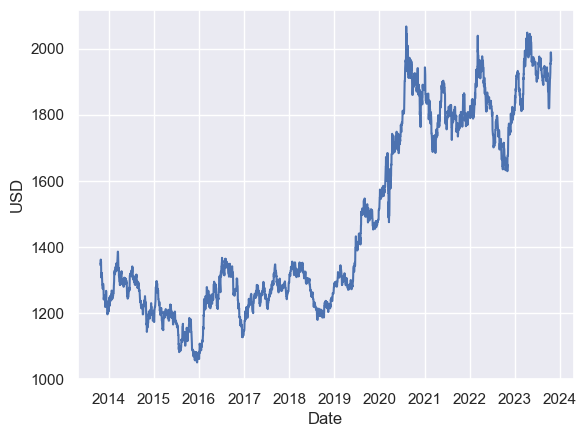

In [10]:
sns.set()
plt.ylabel('USD')
plt.xlabel('Date')
plt.plot(df.index, df)

# Split Data for Training & Testing

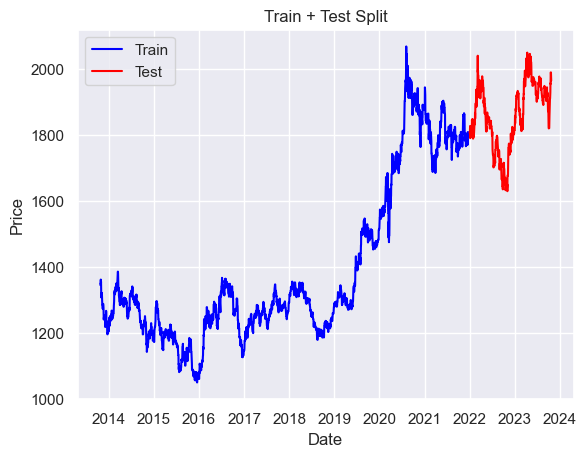

In [11]:
train = df[df.index < "2022-01-01"]
test = df[df.index >= "2022-01-01"]

plt.plot(train, color="blue", label="Train")
plt.plot(test, color="red", label="Test")

plt.ylabel('Price')
plt.xlabel('Date')

plt.title("Train + Test Split")
plt.legend()
plt.show()

# Test if data is stationary

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
#Used Dickey-Fuller test to test for stationarity:
X = df.values 
result = adfuller(X)
print('p-value:', result[1])

if result[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

p-value: 0.8738377443477618
The time series is likely non-stationary.


ADF test fails to reject null- timeseries is non stationary

# Transform Data to Stationary

Date
2013-10-25     3.00
2013-10-26     0.00
2013-10-27     0.00
2013-10-28    13.25
2013-10-29   -11.75
Freq: D, Name: USD (PM), dtype: float64

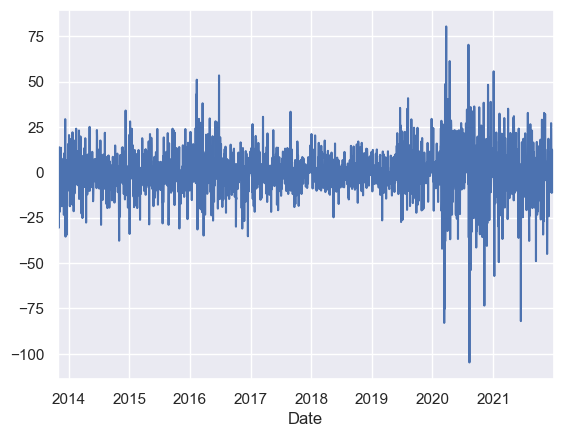

In [14]:
#used differencing method:

train_differenced = train.diff().dropna()
train_differenced.plot()
train_differenced.head()

In [15]:
#Perform Dickey-Fuller test again to test for stationarity

result = adfuller(train_differenced)
print('p-value:', result[1])

if result[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

p-value: 6.55617754767783e-26
The time series is likely stationary.


In [16]:
#time series had to be differenced 1 time to achieve stationarity, so d = 1 for ARIMA and SARIMA analysis

# Determine p and q parameters with ACF and PACF plots

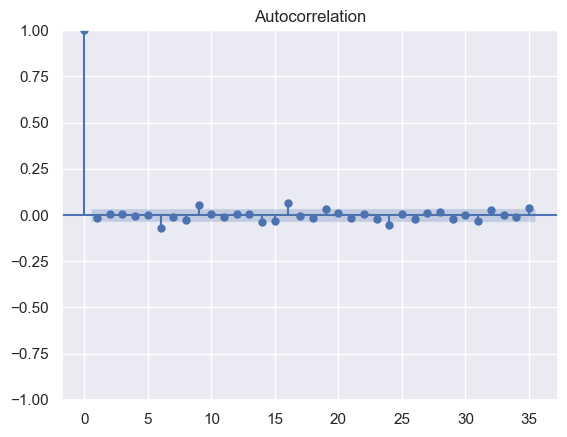

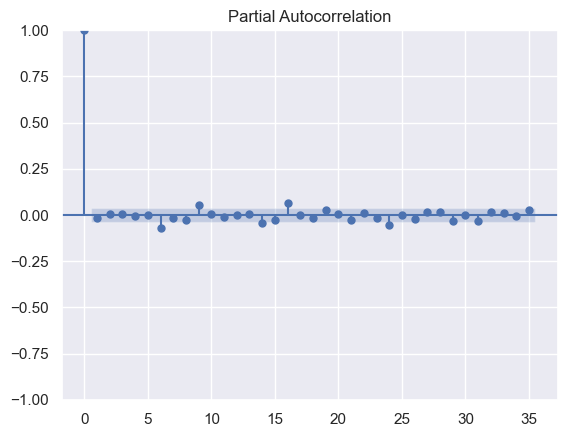

In [18]:
#ACF = correlation of the time series with its lags
#PACF = gives the partial correlation between a data point and its lagged values, after removing the contributions of the intermediate lags
#looking for spikes beyond confidence interval 


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(train_differenced)
pacf = plot_pacf(train_differenced)

In [19]:
#ACF and PACF plots show initial large lag then sharp drop off --> ARIMA(1,1,1)


# ARIMA(1,1,1) model

In [20]:
from statsmodels.tsa.arima.model import ARIMA
ARIMA = ARIMA(train, order=(1,1,1))
ARIMA_fit = ARIMA.fit()
print(ARIMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               USD (PM)   No. Observations:                 2991
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11391.810
Date:                Wed, 01 Nov 2023   AIC                          22789.621
Time:                        15:14:04   BIC                          22807.630
Sample:                    10-24-2013   HQIC                         22796.099
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2865      0.837     -0.342      0.732      -1.926       1.353
ma.L1          0.2696      0.842      0.320      0.749      -1.380       1.919
sigma2       119.3132      1.220     97.773      0.0

## Check Correlation of Residuals

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

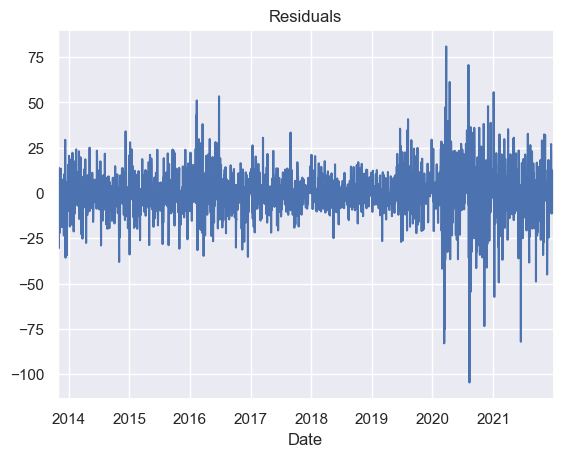

In [22]:
residuals = ARIMA_fit.resid[1:]
residuals.plot(title='Residuals')

## Plot predictions

In [23]:
ARIMAforecast=ARIMA_fit.get_forecast(len(test))


ARIMAforecast_mean= ARIMAforecast.predicted_mean
#interesting issue here- statsmodels doesn't allow you to store "predicted values" very easily.

ARIMAconfidence_interval = ARIMAforecast.conf_int()


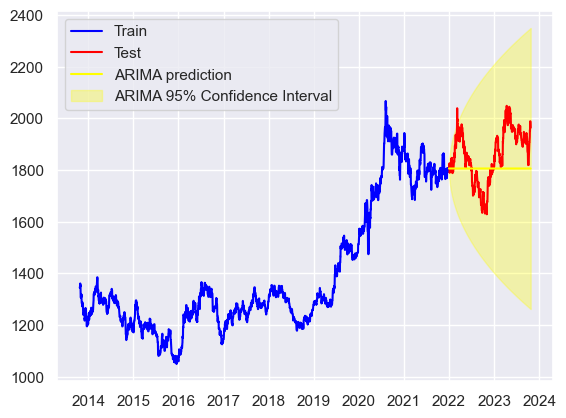

In [24]:
plt.plot(train, color="blue", label="Train")
plt.plot(test, color="red", label="Test")

plt.plot(ARIMAforecast_mean.index, ARIMAforecast_mean, color="yellow", label="ARIMA prediction")
plt.fill_between(ARIMAconfidence_interval.index, ARIMAconfidence_interval.iloc[:, 0], ARIMAconfidence_interval.iloc[:, 1], color='yellow', alpha=0.3, label='ARIMA 95% Confidence Interval')

plt.legend()


## Evaluate ARIMA model output

In [25]:
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse1 = mean_squared_error(test, ARIMAforecast_mean)

rmse1 = math.sqrt(mse1)

mae1= mean_absolute_error(test, ARIMAforecast_mean)

rmae1 = math.sqrt(mae1)

print('RMSE: ' +str(rmse1))
print('RMAE: ' +str(rmae1))

RMSE: 112.12966725347772
RMAE: 9.75905612372422


# SARIMA Model

In [26]:
import statsmodels.api as sm
SARIMA=sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,12))
SARIMA_fit=SARIMA.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92286D+00    |proj g|=  8.06752D-02

At iterate    5    f=  3.80736D+00    |proj g|=  1.88347D-02

At iterate   10    f=  3.80617D+00    |proj g|=  9.18182D-03

At iterate   15    f=  3.80428D+00    |proj g|=  8.73787D-04

At iterate   20    f=  3.80417D+00    |proj g|=  1.83047D-04

At iterate   25    f=  3.80416D+00    |proj g|=  1.06974D-03

At iterate   30    f=  3.80410D+00    |proj g|=  2.05569D-04

At iterate   35    f=  3.80410D+00    |proj g|=  1.74573D-04

At iterate   40    f=  3.80410D+00    |proj g|=  4.73825D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [27]:
SARIMAforecast=SARIMA_fit.get_forecast(len(test))

SARIMAforecast_mean= SARIMAforecast.predicted_mean
confidence_interval = SARIMAforecast.conf_int()

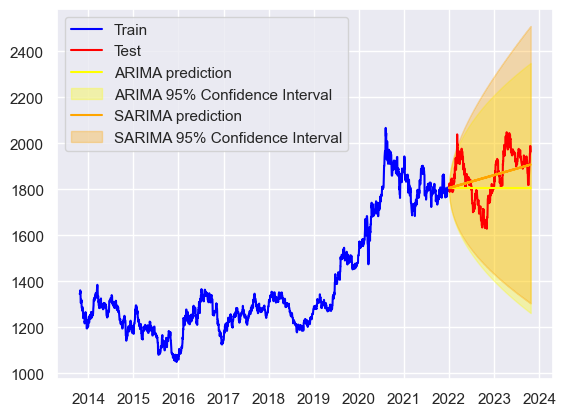

In [28]:
plt.plot(train, color="blue", label="Train")
plt.plot(test, color="red", label="Test")

plt.plot(ARIMAforecast_mean.index, ARIMAforecast_mean, color="yellow", label="ARIMA prediction")
plt.fill_between(ARIMAconfidence_interval.index, ARIMAconfidence_interval.iloc[:, 0], ARIMAconfidence_interval.iloc[:, 1], color='yellow', alpha=0.3, label='ARIMA 95% Confidence Interval')

plt.plot(SARIMAforecast_mean.index, SARIMAforecast_mean, color="orange", label="SARIMA prediction")
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='orange', alpha=0.3, label='SARIMA 95% Confidence Interval')


plt.legend()

## Evaluate SARIMA Model output

In [29]:
mse2 = mean_squared_error(test, SARIMAforecast_mean)

rmse2 = math.sqrt(mse2)

mae2= mean_absolute_error(test, SARIMAforecast_mean)

rmae2 = math.sqrt(mae2)

print('RMSE: ' +str(rmse2))
print('RMAE: ' +str(rmae2))

RMSE: 92.24782444082201
RMAE: 8.635945317725156


# Holt-Winters Exponential Smoothing Model


In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [31]:
HWmodel = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
HWmodel_fit = HWmodel.fit()

In [32]:
HWforecast = HWmodel_fit.forecast(len(test))

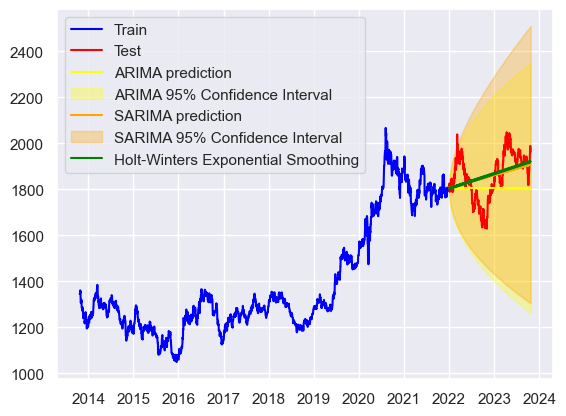

In [33]:
plt.plot(train, color="blue", label="Train")
plt.plot(test, color="red", label="Test")

plt.plot(ARIMAforecast_mean.index, ARIMAforecast_mean, color="yellow", label="ARIMA prediction")
plt.fill_between(ARIMAconfidence_interval.index, ARIMAconfidence_interval.iloc[:, 0], ARIMAconfidence_interval.iloc[:, 1], color='yellow', alpha=0.3, label='ARIMA 95% Confidence Interval')

plt.plot(SARIMAforecast_mean.index, SARIMAforecast_mean, color="orange", label="SARIMA prediction")
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='orange', alpha=0.3, label='SARIMA 95% Confidence Interval')

plt.plot(HWforecast, color="green", label="Holt-Winters Exponential Smoothing")


plt.legend()

In [34]:
mse3 = mean_squared_error(test, HWforecast)

rmse3 = math.sqrt(mse3)

mae3= mean_absolute_error(test, HWforecast)

rmae3 = math.sqrt(mae3)

print('RMSE: ' +str(rmse3))
print('RMAE: ' +str(rmae3))

RMSE: 92.07421277054837
RMAE: 8.560360700192973


# Forecast out 2 years of PX data using Holt-Winter Method

In [35]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,730)]

In [36]:
futurepxs_dataset_df=pd.DataFrame(index=future_dates[1:])

In [37]:
futurepxs_dataset_df.head()

""
2023-10-25
2023-10-26
2023-10-27
2023-10-28
2023-10-29


In [38]:
HWfuturepxs = HWmodel_fit.forecast(steps=3500)

In [39]:
futurepxs_dataset_df['HW Predictions'] = HWfuturepxs

In [40]:
print(futurepxs_dataset_df)

            HW Predictions
2023-10-25     1922.580389
2023-10-26     1922.970236
2023-10-27     1921.600726
2023-10-28     1918.634684
2023-10-29     1917.978880
...                    ...
2025-10-18     2045.597824
2025-10-19     2048.456177
2025-10-20     2049.322651
2025-10-21     2050.431674
2025-10-22     2053.485653

[729 rows x 1 columns]


In [41]:
#Holt-Winters package does not support confidence intervals, so have to make them from scratch

std_dev = np.std(HWmodel_fit.resid)
confidence_interval = 1.96 

lower_bound = HWfuturepxs - confidence_interval * std_dev
upper_bound = HWfuturepxs + confidence_interval * std_dev

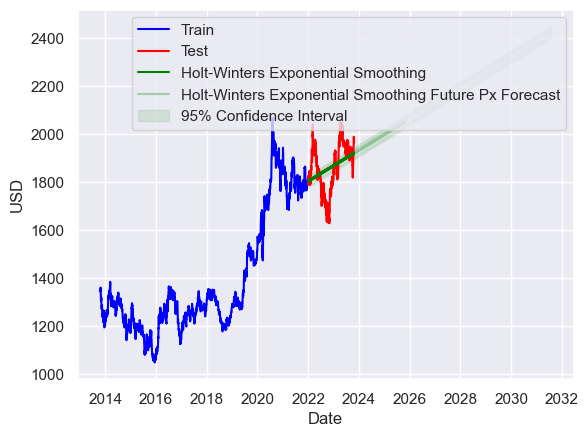

In [42]:
plt.plot(train, color="blue", label="Train")
plt.plot(test, color="red", label="Test")


plt.plot(HWforecast, color="green", label="Holt-Winters Exponential Smoothing")
plt.plot(futurepxs_dataset_df, color="green",alpha= 0.3, label= "Holt-Winters Exponential Smoothing Future Px Forecast")
plt.fill_between(HWfuturepxs.index, lower_bound, upper_bound, color='green', alpha=0.1, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('USD')

plt.legend()

